In this file I attempt to find respecting record in ACMS (input) dataset for each report in output dataset

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
acms_path = './data/neo_takeoff_202403260034.csv'
# acms_path = './data/neo_takeoff_202404192324.csv'

acms_full = pd.read_csv(acms_path, parse_dates=['reportts'], low_memory=False)

# acnum = 'VQ-BGU'
acnum = 'VP-BWB'
# takeoff_reportname = 'A321 ENGINE TAKE OFF REPORT'
# takeoff_reportname = 'A320 ENGINE TAKE OFF REPORT'

acms = acms_full.query(f'acnum == @acnum') \
    .drop(columns=['reportname']) \
    .set_index('reportts') \
    .sort_index()

acms.shape

(4736, 206)

In [4]:
egtm_raw = pd.read_csv('./data/Data EGT N1Vib ACC ITT.csv', parse_dates=['RECORDED_DT']) \
    .drop(columns=['ESN']) \
    .rename(columns={
        'AIRCRAFT': 'acnum',
        'POSITION': 'pos',
        'RECORDED_DT': 'recorded_dt',
        'RWCTOMAR': 'egtm',
        'EGTM': 'egtm'
    }) \
    .loc[:, :'egtm']

egtm_raw['recorded_dt'] = pd.to_datetime(egtm_raw['recorded_dt'], format='%m/%d/%Y %I:%M:%S', errors='raise')

egtm = egtm_raw.query(f'acnum == @acnum and egtm > 0')

egtm.head()

,acnum,pos,recorded_dt,egtm
9469,VP-BWB,2,2019-03-02 02:03:26,126.805
9470,VP-BWB,2,2019-03-02 10:47:56,130.239
9471,VP-BWB,2,2019-03-02 16:20:39,129.515
9472,VP-BWB,2,2019-03-02 22:16:46,129.676
9473,VP-BWB,2,2019-03-03 04:54:28,129.296


In [61]:
egtm_raw.groupby('acnum').count()

,pos,recorded_dt,egtm
acnum,,,
VP-BWB,1475,1475,1466
VP-BWM,1250,1250,1238
VP-BWN,991,991,986
VQ-BCR,2843,2843,2817
VQ-BDQ,1294,1294,1284
VQ-BDU,2260,2260,2245
VQ-BGU,1813,1813,1779
VQ-BRA,8,8,8
VQ-BRI,1251,1251,1241


In [48]:
n1_raw = pd.read_csv('./data/Data N1.csv', parse_dates=['RECORDED_DT']) \
    .drop(columns=['ESN']) \
    .rename(columns={
        'AIRCRAFT': 'acnum',
        'POSITION': 'pos',
        'RECORDED_DT': 'recorded_dt',
        'EGTM': 'egtm',
        'DELTA N1 (Actual vs Cmd)': 'n1_delt'
    }) \
    .loc[:, :'n1_delt']

n1_raw.shape

(4631, 5)

In [49]:
n2_raw = pd.read_csv('./data/Data N2.csv', parse_dates=['RECORDED_DT']) \
    .drop(columns=['ESN', 'ACC Valve Tprq mtr curr']) \
    .rename(columns={
        'AIRCRAFT': 'acnum',
        'POSITION': 'pos',
        'RECORDED_DT': 'recorded_dt',
        'EGTM': 'egtm',
        'N2 Delt': 'n2_delt'
    }) \
    .loc[:, :'n2_delt']

n2_raw.shape

(4394, 5)

In [35]:
if 'n1_delt' not in egtm.columns:
  egtm = pd.merge(egtm, n1_raw, on=['acnum', 'pos', 'egtm', 'recorded_dt'])
if 'n2_delt' not in egtm.columns:
  egtm = pd.merge(egtm, n2_raw, on=['acnum', 'pos', 'egtm', 'recorded_dt'])
egtm = egtm.set_index('recorded_dt').sort_index()
egtm

,acnum,pos,egtm,n1_delt,n2_delt
recorded_dt,,,,,
2018-05-20 19:36:47,VQ-BDQ,1,132.144,NaN,NaN
2018-05-20 19:36:47,VQ-BDQ,2,136.971,NaN,NaN
2018-05-22 01:48:50,VQ-BDQ,2,132.749,NaN,NaN
2018-05-22 01:48:50,VQ-BDQ,1,127.592,NaN,NaN
2018-05-23 19:51:23,VQ-BDQ,1,128.712,NaN,NaN
...,...,...,...,...,...
2020-02-02 04:14:45,VQ-BDQ,1,106.549,-0.090004,-0.220833
2020-02-02 16:24:00,VQ-BDQ,2,102.562,0.170006,-0.255308
2020-02-02 16:24:00,VQ-BDQ,1,106.186,0.160004,-0.232732


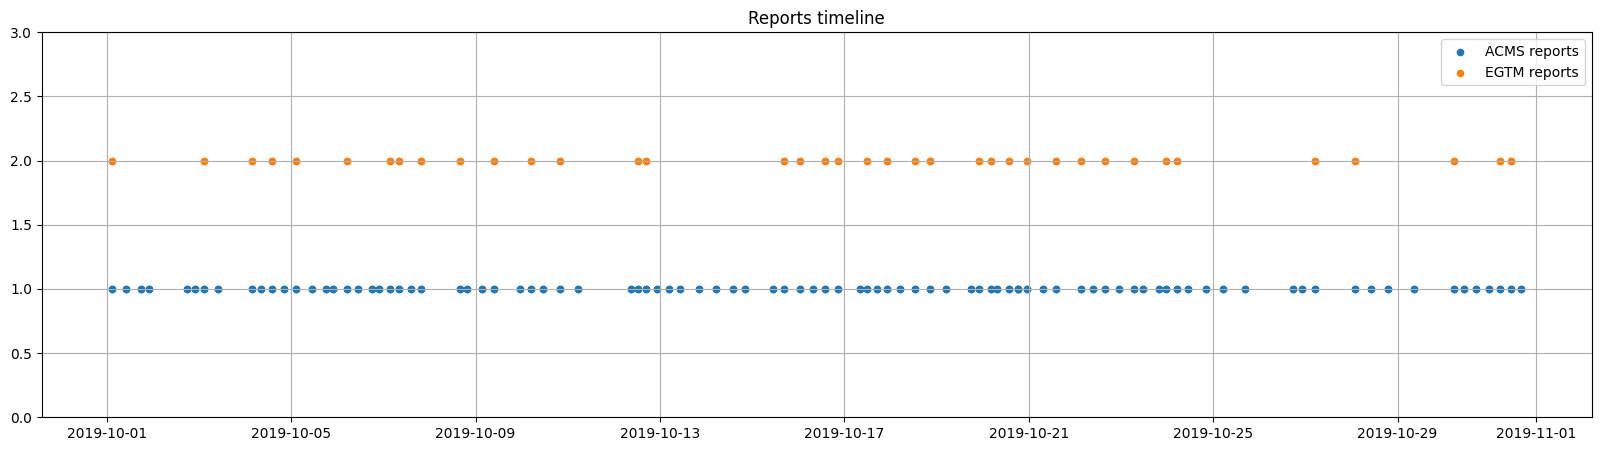

In [20]:
acms_filtered = acms[
    (pd.to_datetime(acms.index).year == 2019) &
    (pd.to_datetime(acms.index).month == 10)
    # (pd.to_datetime(acms.index).day <= 15)  
    # (pd.to_datetime(acms.index).day <= 21)
]

acms_line = acms_filtered.index

egtm_filtered = egtm[
    (pd.to_datetime(egtm.index).year == 2019) &
    (pd.to_datetime(egtm.index).month == 10) 
    # (pd.to_datetime(egtm.index).day <= 15) 
    # (pd.to_datetime(egtm.index).day <= 21) 
]

egtm_line = egtm_filtered.index

fig, ax = plt.subplots(figsize=(20, 5))

ax.scatter(acms_line, y=acms_line.map(lambda _ : 1), s=20)
ax.scatter(egtm_line, y=egtm_line.map(lambda _: 2), s=20)
ax.legend(["ACMS reports", "EGTM reports"])
ax.set_ylim([0, 3])
ax.set_title("Reports timeline")
ax.grid(which='minor', alpha=1)
ax.grid(which='major', alpha=1)
plt.show()

Для 1672 записей разница во времени *delta_t = output_t - input_t* составляет не более +30 секунд. Эти записи являются наиболее чистыми данными, которые в дальнейшем я буду использовать для построения baseline-моделей. Есть также небольшая часть данных, для которых delta_t отрицательна. На данный момент эти записи я не включаю в датасет, так как нет уверенности в их корректности. 

Датасет `takeoff-merged-VQ-BGU-30s.csv` будет основным для борта VQ-BGU.

In [37]:
# merged_sample.drop(columns=['reportts_']) \
#              .to_csv('./takeoff-merged-VQ-BGU-30s-full.csv', index=False)

In [5]:
res = []

for pos in [1, 2]:
  egtm_to_merge = egtm \
    .query(f'pos=={pos}') \
    .reset_index().rename(columns={'recorded_dt': 'reportts'}) \
    .set_index('reportts').sort_index() \
    .drop(columns=['acnum', 'pos'])

  m = pd.merge_asof( 
    acms.query(f'pos=={pos}'),
    egtm_to_merge,
    on='reportts',
    direction='nearest',
    tolerance=pd.to_timedelta('15 sec')
  )
  res.append(m)

merged2 = pd.concat(res).dropna(subset=['egtm'])
merged2.shape

(366, 209)

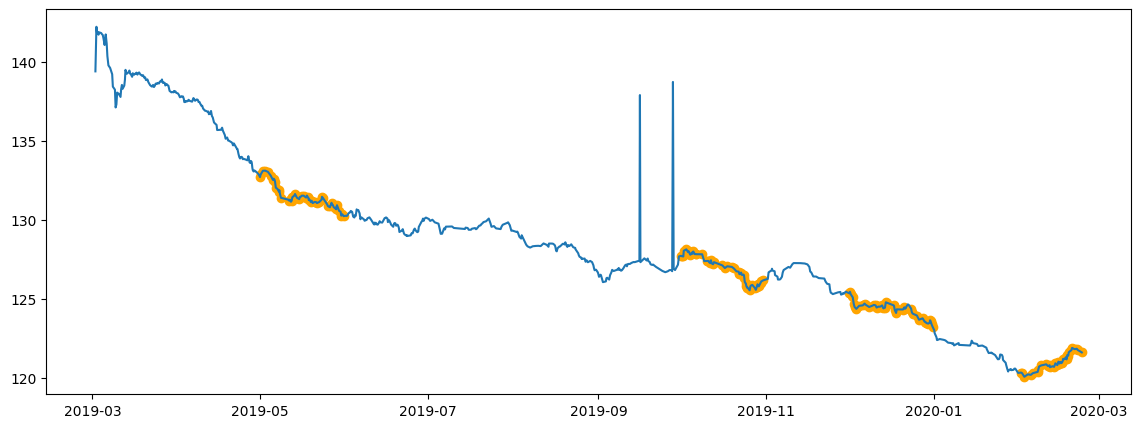

In [11]:
plt.figure(figsize=(14, 5))
m = merged2.query('pos==1 and egtm > 80 and egtm < 150')
e = egtm_raw.query('acnum==@acnum and pos==1 and egtm > 80 and egtm < 150')
plt.plot(e['recorded_dt'], e['egtm'])
plt.scatter(m['reportts'], m['egtm'], color='orange')

In [42]:
# merged2.to_csv('./data/takeoff-merged-VQ-BGU-2.csv', index=False)